# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

We need to develop a regression model that predicts the resale price of a used car from features such as make, model, year, mileage, condition, and fuel type etc. The task is to analyze the dataset of 426,000 car sales, identify which features most affect price, and evaluate model performance with metrics. The insights will be summarized in reports that help the dealer choose and price inventory more effectively to improve profitability.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

The dataset consists of 426,000 records of used car sales. Before modeling, it is essential to explore and prepare the data properly.

Planned exploration steps:

1. Import the dataset for analysis
2. Check for missing values and decide whether to remove, impute, or adjust them.
3. Check for duplicates and remove.
4. Remove outliers

In [1]:
# Import Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re
import warnings

from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, root_mean_squared_error, make_scorer, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn import set_config
from sklearn.compose import make_column_transformer
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, QuantileTransformer


set_config(display="diagram")


In [2]:
# Read vehicles.csv file
data_df = pd.read_csv('data/vehicles.csv')
data_df.head()

id                  region  price  year manufacturer model  \
0  7222695916                prescott   6000   NaN          NaN   NaN   
1  7218891961            fayetteville  11900   NaN          NaN   NaN   
2  7221797935            florida keys  21000   NaN          NaN   NaN   
3  7222270760  worcester / central MA   1500   NaN          NaN   NaN   
4  7210384030              greensboro   4900   NaN          NaN   NaN   

  condition cylinders fuel  odometer title_status transmission  VIN drive  \
0       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
1       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
2       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
3       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
4       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   

  size type paint_color state  
0  NaN  NaN         NaN    az  
1  NaN  NaN         NaN    ar  
2  NaN  NaN         NaN    fl  
3  NaN  NaN         NaN    ma  
4  NaN  NaN         NaN    nc

In [3]:
#Get the summary of a DataFrame to get details about rows count, data tyoe, column's non null count
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [4]:
# Get colums with missing data %
missing_percent = (data_df.isnull().sum() / data_df.shape[0]) * 100
missing_percent[missing_percent > 0].sort_values(ascending=False)

size            71.767476
cylinders       41.622470
condition       40.785232
VIN             37.725356
drive           30.586347
paint_color     30.501078
type            21.752717
manufacturer     4.133714
title_status     1.930753
model            1.236179
odometer         1.030735
fuel             0.705819
transmission     0.598763
year             0.282281
dtype: float64

In [5]:
# Rows count if we drop all null values
data_df.dropna().shape[0]

34868

In [6]:
# Check for duplicates
data_df.duplicated().sum()

0

In [7]:
for col in data_df.columns:
    print(f"{data_df[col].value_counts()}")
    print("---------------------------------------")

id
7222695916    1
7313139418    1
7313423023    1
7313423324    1
7313424533    1
             ..
7314655506    1
7314655833    1
7314657468    1
7314659947    1
7301591129    1
Name: count, Length: 426880, dtype: int64
---------------------------------------
region
columbus                   3608
jacksonville               3562
spokane / coeur d'alene    2988
eugene                     2985
fresno / madera            2983
                           ... 
meridian                     28
southwest MS                 14
kansas city                  11
fort smith, AR                9
west virginia (old)           8
Name: count, Length: 404, dtype: int64
---------------------------------------
price
0        32895
6995      3169
7995      3129
9995      2867
8995      2837
         ...  
21298        1
49217        1
63195        1
19709        1
17873        1
Name: count, Length: 15655, dtype: int64
---------------------------------------
year
2017.0    36420
2018.0    36369
2015.0    31

**Observations:**

1. Out of 18 columns, 14 contain null values. Features such as size, cylinders, condition, VIN, drive, paint_color, and type have the highest proportion of missing data.

2. Dropping all rows with null values would reduce the dataset to ~35K rows (less than 10% of the original 426K), leading to a significant loss of information. Alternative strategies to handle missing data should be applied.

3. There are no duplicate rows in the dataset.

4. Columns like Id and VIN are expected to be unique and are not useful for regression, so they can be removed.

5. Approximately 32,895 rows (7.7%) in the price column have a value of "0", which is unrealistic for used car sales. These erroneous records will be removed.

6. Categorical columns — condition, model, drive, transmission, size, type, paint_color, fuel, title_status, and cylinders — will have missing values filled with "Other".

7. The state column uses standardized abbreviations (e.g., AZ, AR, FL), making it more consistent. The more detailed region column with city names was dropped as redundant.

8. The odometer column has 1% missing values, which will be filled with the mean value.

9. The model column will be dropped because it has too many unique values, which would create high dimensionality during encoding and block the pipeline.

10. Rows with null values in the Year and manufacturer columns will be dropped.

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [8]:
#Drop 'id', 'VIN', 'region', 'model' columns
data_clean_df = data_df.drop({'id', 'VIN', 'region', 'model'}, axis=1)

#Fill missing values with 'other' for below features
data_clean_df['type'] = data_clean_df['type'].fillna('other')
data_clean_df['cylinders'] = data_clean_df['cylinders'].fillna('other')
data_clean_df['condition'] = data_clean_df['condition'].fillna('other')
data_clean_df['drive'] = data_clean_df['drive'].fillna('other')
data_clean_df['paint_color'] = data_clean_df['paint_color'].fillna('other')
data_clean_df['size'] = data_clean_df['paint_color'].fillna('other')
data_clean_df['title_status'] = data_clean_df['title_status'].fillna('other')
data_clean_df['transmission'] = data_clean_df['transmission'].fillna('other')
data_clean_df['fuel'] = data_clean_df['fuel'].fillna('other')

#Remove rows that have missing manufacturer and year
data_clean_df = data_clean_df.dropna(subset=['manufacturer', 'year'], how='any')
data_clean_df['year'] = data_clean_df['year'].apply(lambda x: int(x))

#Fill missing values of odometer column with mean value
data_clean_df["odometer"] = data_clean_df["odometer"].fillna(data_clean_df["odometer"].mean())
data_clean_df['odometer'] = data_clean_df['odometer'].apply(lambda x: int(x))

#Remove rows that has "0" price value
cars_df = data_clean_df[data_clean_df['price'] != 0]

cars_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 377796 entries, 27 to 426879
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   price         377796 non-null  int64 
 1   year          377796 non-null  int64 
 2   manufacturer  377796 non-null  object
 3   condition     377796 non-null  object
 4   cylinders     377796 non-null  object
 5   fuel          377796 non-null  object
 6   odometer      377796 non-null  int64 
 7   title_status  377796 non-null  object
 8   transmission  377796 non-null  object
 9   drive         377796 non-null  object
 10  size          377796 non-null  object
 11  type          377796 non-null  object
 12  paint_color   377796 non-null  object
 13  state         377796 non-null  object
dtypes: int64(3), object(11)
memory usage: 43.2+ MB


In [9]:
for col in cars_df.columns:
    print(f"{cars_df[col].value_counts()}")
    print("---------------------------------------")

price
6995     3089
7995     3051
8995     2778
9995     2775
4500     2649
         ... 
23397       1
35693       1
48300       1
11027       1
19853       1
Name: count, Length: 15387, dtype: int64
---------------------------------------
year
2018    32226
2017    32006
2013    27266
2015    27216
2014    26331
        ...  
1915        1
1905        1
1918        1
1945        1
1916        1
Name: count, Length: 108, dtype: int64
---------------------------------------
manufacturer
ford               64855
chevrolet          50643
toyota             31600
honda              19867
jeep               17461
nissan             17395
ram                16464
gmc                15431
bmw                13745
dodge              12369
mercedes-benz      10462
hyundai             9374
subaru              8986
volkswagen          8898
lexus               7741
kia                 7547
audi                7180
cadillac            6591
acura               5707
chrysler            5656
buick   

In [10]:
# Re-evaluating missed values using heatmap
ax = sns.heatmap(
	cars_df.isna()
)
ax.set_title("Cleaned Cars dataframe Heatmap - Evaluating missed values")
plt.show()

In [11]:
#Remove outliers

std = cars_df['price'].std() 
mean = cars_df['price'].mean()
print(std, mean)

12946354.768285614 83402.72354657011


In [12]:
cars_df[cars_df['price']>150000].shape[0]

139

In [13]:
#Standard deviation of price is too high
#Only 139 car are above $150_000, so drop them
cars_df = cars_df[cars_df['price']<=150000]

In [14]:
std = cars_df['year'].std() 
mean = cars_df['year'].mean()

print(std, mean)

cars_df = cars_df[cars_df['year']>= mean-2*std]
cars_df = cars_df[cars_df['year']<= mean+2*std]

9.094127422750839 2011.2952388013462


In [15]:
std = cars_df['odometer'].std() 
mean = cars_df['odometer'].mean()

print(std, mean)

cars_df = cars_df[cars_df['odometer']<= mean+2*std]

135735.32041497415 95383.22439949431


In [16]:
cars_df.describe()

price           year       odometer
count  364642.000000  364642.000000  364642.000000
mean    18952.656411    2012.528189   92420.092148
std     14639.327856       5.546877   62241.117347
min         1.000000    1994.000000       0.000000
25%      7499.000000    2009.000000   38638.000000
50%     15762.000000    2014.000000   88000.000000
75%     27950.000000    2017.000000  135000.000000
max    150000.000000    2022.000000  366356.000000

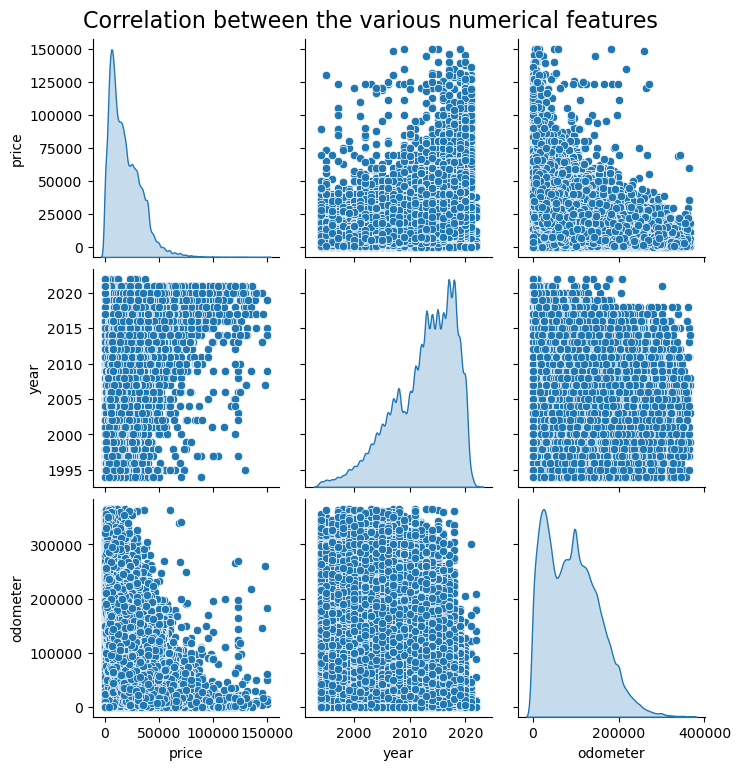

In [17]:
#Determine the correlation between the various numerical features
sns.pairplot(data = cars_df, diag_kind = 'kde')
plt.suptitle('Correlation between the various numerical features', y=1.02, fontsize=16)  # y shifts title above the plot
plt.show()

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [18]:
# To get different models results
results = []

In [19]:
#Model 1 :  Linear regression with only numerical features

X = cars_df.drop('price', axis = 1)

#drop all categorical columns to get base line error
X = X.drop(['manufacturer', 'fuel','title_status','transmission',
            'state', 'condition', 'drive', 'type', 
            'paint_color', 'size', 'cylinders'], axis=1)

y = cars_df['price']

#70% training data, 30% testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)


In [20]:
pipe = Pipeline([
                ('normalize', QuantileTransformer(output_distribution='normal')),
                ('scaler', StandardScaler(with_mean=False)), 
                ('model', LinearRegression())])

pipe

Pipeline(steps=[('normalize',
                 QuantileTransformer(output_distribution='normal')),
                ('scaler', StandardScaler(with_mean=False)),
                ('model', LinearRegression())])

In [21]:
pipe.fit(X_train, y_train)

pred_train = pipe.predict(X_train)
pred_test = pipe.predict(X_test)

#RMSE is used over MSE because it expresses prediction errors in the same units as car prices,
#making them easy to interpret for business decisions.
base_train_rmse = root_mean_squared_error(y_train, pred_train)
base_test_rmse = root_mean_squared_error(y_test, pred_test)

#Evaluation metric
base_train_r2 = r2_score(y_train, pred_train)
base_test_r2 = r2_score(y_test, pred_test)

# Reporting results for this regression model
reg_results = {
    'model': 'linear Regression with numeric features',
    'train_rmse': base_train_rmse,
    'test_rmse': base_test_rmse,
    'train_r2': base_train_r2,
    'test_r2': base_test_r2
}
results.append(reg_results)

print('Baseline Train LinReg RMSE: ', base_train_rmse)
print('Baseline Test LinReg RMSE:  ', base_test_rmse)
print('Baseline Train LinReg R2: ',base_train_r2)
print('Baseline Test LinReg R2: ',base_test_r2)

Baseline Train LinReg RMSE:  11610.667621108683
Baseline Test LinReg RMSE:   11584.49153910357
Baseline Train LinReg R2:  0.37227395196553503
Baseline Test LinReg R2:  0.3707214139429713


In [22]:
#Model 2 :  Lasso regression with categorical features

#Encode categorized columns, normalize, scale, feature select, and lasso regression

col_transformer = make_column_transformer((OneHotEncoder(drop = 'if_binary'), ['manufacturer', 'fuel','title_status',
                                                                               'transmission','state', 'condition', 
                                                                               'drive', 'type', 'paint_color', 'size', 'cylinders']), 

                                          remainder='passthrough'
                                          )


lasso_pipe = Pipeline([
                ('col_transformer', col_transformer), 
                ('normalize', QuantileTransformer(output_distribution='normal')),
                ('scaler', StandardScaler(with_mean=False)), 
                ('model', Lasso(alpha=0.5, tol=1e-2))])

lasso_pipe

Pipeline(steps=[('col_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['manufacturer', 'fuel',
                                                   'title_status',
                                                   'transmission', 'state',
                                                   'condition', 'drive', 'type',
                                                   'paint_color', 'size',
                                                   'cylinders'])])),
                ('normalize',
                 QuantileTransformer(output_distribution='normal')),
                ('scaler', StandardScaler(with_mean=False)),
                ('model', Lasso(alpha=0.5, tol=0.01))])

In [23]:
X1 = cars_df.drop('price', axis=1)

y1 = cars_df['price']

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.30, random_state=42)

lasso_pipe.fit(X1_train, y1_train)

lasso_pred_train = lasso_pipe.predict(X1_train)
lasso_pred_test = lasso_pipe.predict(X1_test)

#RMSE is used over MSE because it expresses prediction errors in the same units as car prices,
#making them easy to interpret for business decisions.
lasso_train_rmse = root_mean_squared_error(y1_train, lasso_pred_train)
lasso_test_rmse = root_mean_squared_error(y1_test, lasso_pred_test)

#Evaluation metric
lasso_train_r2 = r2_score(y1_train, lasso_pred_train)
lasso_test_r2 = r2_score(y1_test, lasso_pred_test)

# Reporting results for this regression model
reg_results = {
    'model': 'Lasso Regression',
    'train_rmse': lasso_train_rmse,
    'test_rmse': lasso_test_rmse,
    'train_r2': lasso_train_r2,
    'test_r2': lasso_test_r2,
    'hyperParams': 'alpha=0.5'
}
results.append(reg_results)

print('Train Lasso RMSE: ', lasso_train_rmse)
print('Test Lasso RMSE:  ', lasso_test_rmse)

print('Train Lasso R2: ',lasso_train_r2)
print('Test Lasso R2: ',lasso_test_r2)

Train Lasso RMSE:  8731.089008033412
Test Lasso RMSE:   8707.751200929995
Train Lasso R2:  0.6450292269988007
Test Lasso R2:  0.6444497212304281


In [24]:
#Model 3 :  Ridge regression with categorical features
ridge_pipe = Pipeline([
                ('col_transformer', col_transformer),
                ('normalize', QuantileTransformer(output_distribution='normal')),    
                ('scaler', StandardScaler(with_mean=False)), 
                ('model', Ridge(alpha=0.5))])

ridge_pipe

Pipeline(steps=[('col_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['manufacturer', 'fuel',
                                                   'title_status',
                                                   'transmission', 'state',
                                                   'condition', 'drive', 'type',
                                                   'paint_color', 'size',
                                                   'cylinders'])])),
                ('normalize',
                 QuantileTransformer(output_distribution='normal')),
                ('scaler', StandardScaler(with_mean=False)),
                ('model', Ridge(alpha=0.5))])

In [25]:
X2 = cars_df.drop('price', axis = 1)

y2 = cars_df['price']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.30, random_state=42)

ridge_pipe.fit(X2_train, y2_train)

ridge_pred_train = ridge_pipe.predict(X2_train)
ridge_pred_test = ridge_pipe.predict(X2_test)

#RMSE is used over MSE because it expresses prediction errors in the same units as car prices,
#making them easy to interpret for business decisions.
ridge_train_rmse = root_mean_squared_error(y2_train, ridge_pred_train)
ridge_test_rmse = root_mean_squared_error(y2_test, ridge_pred_test)

#Evaluation metric
ridge_train_r2 = r2_score(y2_train, ridge_pred_train)
ridge_test_r2 = r2_score(y2_test, ridge_pred_test)

# Reporting results for this regression model
reg_results = {
    'model': 'Ridge Regression',
    'train_rmse': ridge_train_rmse,
    'test_rmse': ridge_test_rmse,
    'train_r2': ridge_train_r2,
    'test_r2': ridge_test_r2,
    'hyperParams': 'alpha=0.5'
}
results.append(reg_results)


print('Train Ridge RMSE: ', ridge_train_rmse)
print('Test Ridge RMSE:  ', ridge_test_rmse)

print('Train Ridge R2: ', ridge_train_r2)
print('Test Ridge R2:  ', ridge_test_r2)

Train Ridge RMSE:  8733.508586408312
Test Ridge RMSE:   8711.414792198866
Train Ridge R2:  0.6448324591929573
Test Ridge R2:   0.6441504786625474


In [26]:
#Model 4 :  Linear regression with categorical features

linreg_pipe = Pipeline([
                ('col_transformer', col_transformer), 
                ('normalize', QuantileTransformer(output_distribution='normal')),
                ('scaler', StandardScaler(with_mean=False)), 
                ('model', LinearRegression())])

linreg_pipe

Pipeline(steps=[('col_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['manufacturer', 'fuel',
                                                   'title_status',
                                                   'transmission', 'state',
                                                   'condition', 'drive', 'type',
                                                   'paint_color', 'size',
                                                   'cylinders'])])),
                ('normalize',
                 QuantileTransformer(output_distribution='normal')),
                ('scaler', StandardScaler(with_mean=False)),
                ('model', LinearRegression())])

In [27]:
X3 = cars_df.drop('price', axis = 1)

y3 = cars_df['price']

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.30, random_state=42)

linreg_pipe.fit(X3_train, y3_train)

linreg_pred_train = linreg_pipe.predict(X3_train)
linreg_pred_test = linreg_pipe.predict(X3_test)

#RMSE is used over MSE because it expresses prediction errors in the same units as car prices,
#making them easy to interpret for business decisions.
linreg_train_rmse = root_mean_squared_error(y3_train, linreg_pred_train)
linreg_test_rmse = root_mean_squared_error(y3_test, linreg_pred_test)

#Evaluation metric
linreg_train_r2 = r2_score(y3_train, linreg_pred_train)
linreg_test_r2 = r2_score(y3_test, linreg_pred_test)


print('Train LinReg RMSE: ', linreg_train_rmse)
print('Test LinReg RMSE:  ', linreg_test_rmse)

print('Train LinReg RMSE: ', linreg_train_r2)
print('Test LinReg RMSE:  ', linreg_test_r2)

# Reporting results
reg_results = {
    'model': 'Linear Regression',
    'train_rmse': linreg_train_rmse,
    'test_rmse': linreg_test_rmse,
    'train_r2': linreg_train_r2,
    'test_r2': linreg_test_r2
}
results.append(reg_results)


#K-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validated negative RMSE scores
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)
rmse_scores = cross_val_score(linreg_pipe, X3, y3, cv=kf, scoring=rmse_scorer)
rmse_scores = -rmse_scores
print("Linear Regression Cross validation RMSE scores for each fold:", rmse_scores)
print("Linear Regression Cross validation Average RMSE:", np.mean(rmse_scores))

# Cross-validated R^2 scores
r2_scores = cross_val_score(linreg_pipe, X3, y3, cv=kf, scoring='r2')
print("Linear Regression Cross validation R² scores for each fold:", r2_scores)
print("Linear Regression Cross validation Average R²:", np.mean(r2_scores))



Train LinReg RMSE:  8728.932789609069
Test LinReg RMSE:   8706.189827766782
Train LinReg RMSE:  0.6452045315936171
Test LinReg RMSE:   0.6445772161207615
Linear Regression Cross validation RMSE scores for each fold: [8708.41025627 8817.56312368 8691.71681636 8689.84156144 8762.37097037]
Linear Regression Cross validation Average RMSE: 8733.980545624985
Linear Regression Cross validation R² scores for each fold: [0.64720471 0.63714392 0.64496529 0.64782942 0.64431107]
Linear Regression Cross validation Average R²: 0.6442908803875399


In [28]:
#Model 5 :  Ridge regression using GridSearchCV 

ridge_gscf_pipe = Pipeline([ ('col_transformer', col_transformer),
                            ('normalize', QuantileTransformer(output_distribution='normal')),                            
                            ('scale', StandardScaler(with_mean=False)),
                            ('model', Ridge())])

# Params to iterate over the selector
param_dict = {'model__alpha': [0.1, 1.0, 10.0, 100.0]}
gscv_sf = GridSearchCV(ridge_gscf_pipe, param_grid=param_dict)



In [29]:
X4 = cars_df.drop('price', axis = 1)
y4 = cars_df['price']

X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.30, random_state=42)

In [30]:

gscv_sf.fit(X4_train, y4_train)

# Obtaining predictions
ridge_gscv_pred_train = gscv_sf.best_estimator_.predict(X4_train)
ridge_gscv_pred_test = gscv_sf.best_estimator_.predict(X4_test)

# Calculating errors
ridge_gscv_train_rmse = root_mean_squared_error(y4_train, ridge_gscv_pred_train)
ridge_gscv_test_rmse = root_mean_squared_error(y4_test, ridge_gscv_pred_test)

ridge_gscv_train_r2 = r2_score(y4_train, ridge_gscv_pred_train)
ridge_gscv_test_r2 = r2_score(y4_test, ridge_gscv_pred_test)

# Reporting results
reg_results = {
    'model': 'Ridge with Grid search',
    'train_rmse': ridge_gscv_train_rmse,
    'test_rmse': ridge_gscv_test_rmse,
    'train_r2': ridge_gscv_train_r2,
    'test_r2': ridge_gscv_test_r2,
    'hyperParams': gscv_sf.best_params_
}
results.append(reg_results)

print('Train Ridge GSCV RMSE: ', ridge_gscv_train_rmse)
print('Test Ridge GSCV RMSE:  ', ridge_gscv_test_rmse)

print('Train Ridge GSCV RMSE: ', ridge_gscv_train_r2)
print('Test Ridge GSCV RMSE:  ', ridge_gscv_test_r2)

Train Ridge GSCV RMSE:  8734.457069311402
Test Ridge GSCV RMSE:   8712.248535279768
Train Ridge GSCV RMSE:  0.644755310672549
Test Ridge GSCV RMSE:   0.6440823608468206


In [31]:
# Model 6 : Linear regression with Sequential Feature Selector 

selector = SequentialFeatureSelector(LinearRegression(), n_features_to_select=3)
ligreg_sfs_pipe = Pipeline([ ('col_transformer', col_transformer),
                            ('column_selector', selector),
                            ('normalize', QuantileTransformer(output_distribution='normal')),
                            ('scale', StandardScaler(with_mean=False)),
                            ('linreg', LinearRegression())])


In [32]:
X5 = cars_df.drop('price', axis = 1)
y5 = cars_df['price']

X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size=0.30, random_state=42)

In [33]:
ligreg_sfs_pipe.fit(X5_train, y5_train)

linreg_sfs_pred_train = ligreg_sfs_pipe.predict(X5_train)
linreg_sfs_pred_test = ligreg_sfs_pipe.predict(X5_test)


# Calculating errors
linreg_sfs_train_rmse = root_mean_squared_error(y5_train, linreg_sfs_pred_train)
linreg_sfs_test_rmse = root_mean_squared_error(y5_test, linreg_sfs_pred_test)

linreg_sfs_train_r2 = r2_score(y5_train, linreg_sfs_pred_train)
linreg_sfs_test_r2 = r2_score(y5_test, linreg_sfs_pred_test)

# Reporting results
reg_results = {
    'model': 'Linear regression with SFS',
    'train_rmse': linreg_sfs_train_rmse,
    'test_rmse': linreg_sfs_test_rmse,
    'train_r2': linreg_sfs_train_r2,
    'test_r2': linreg_sfs_test_r2,

}
results.append(reg_results)

print('Train linear regression SFS RMSE: ', linreg_sfs_train_rmse)
print('Test linear regression SFS RMSE:  ', linreg_sfs_test_rmse)

print('Train linear regression SFS R2: ', linreg_sfs_train_r2)
print('Test linear regression SFS R2:  ', linreg_sfs_test_r2)

Train linear regression SFS RMSE:  10476.041527347052
Test linear regression SFS RMSE:   10484.826737426578
Train linear regression SFS R2:  0.4889655384513809
Test linear regression SFS R2:   0.48452036057709646


In [34]:
train_obs_df = pd.DataFrame()
train_obs_df['price'] = y1_train
train_obs_df['Lasso'] = lasso_pred_train
train_obs_df['Ridge'] = ridge_pred_train
train_obs_df['LinReg'] = linreg_pred_train
train_obs_df['Ridge GSCV'] = ridge_gscv_pred_train
train_obs_df['LinReg SFS'] = linreg_sfs_pred_train

In [35]:
train_obs_df.sample(10)

price         Lasso         Ridge        LinReg    Ridge GSCV  \
364128  10250  12667.855957  12617.747267  12632.637117  12722.538495   
323406  10965  16093.144846  16101.923439  16054.559714  16116.784066   
241448  29990  28001.726748  27941.633705  28061.034407  28034.345804   
81675     750   6148.815977   6111.327101   6194.274212   6071.747307   
44721   10677   8827.073897   8735.293877   8780.668196   8795.625202   
409983  40950  40653.065465  40642.101995  40594.658610  40713.891551   
350225  14995  15350.003727  15501.618824  15389.780204  15445.560817   
31634    7500   3279.834080   3171.006078   3229.627973   3215.834052   
271000  11999  20301.269110  20370.987447  20323.008959  20313.508980   
299929   7881   8444.035088   8438.325472   8397.199283   8519.963601   

          LinReg SFS  
364128   9804.445185  
323406  15099.567006  
241448  28760.767268  
81675   -1835.171944  
44721    8456.088375  
409983  32749.787887  
350225  20617.852006  
31634    5893.401184  
271000  19045.106750  
299929   9804.445185

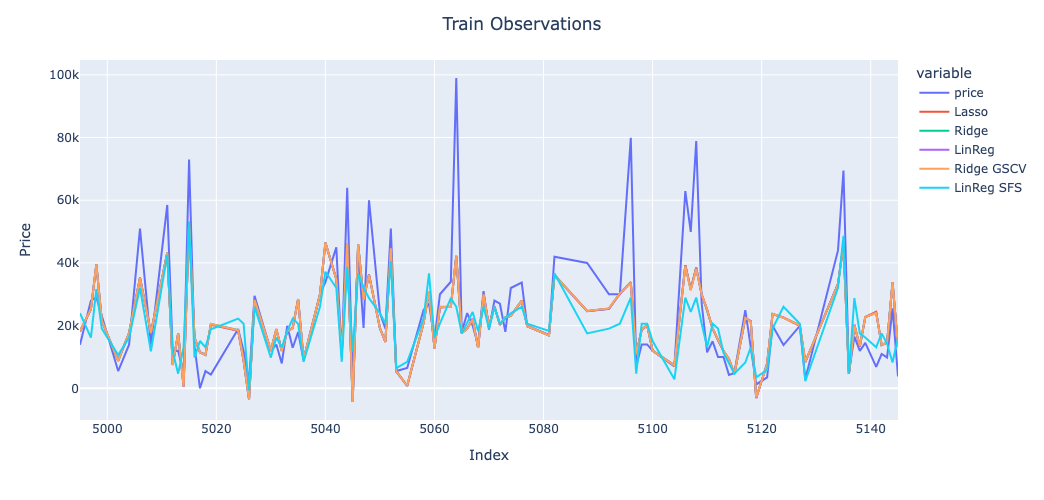

In [36]:
fig = train_obs_df.sort_index()[3000:3100].plot(kind='line', backend='plotly')

fig.update_layout(
    width=1000,   # increase width
    height=500,   # optional: increase height
    title=dict(
        text='Train Observations',
        x=0.5,          # centers the title
        xanchor='center' # ensures proper alignment
    ),
    xaxis_title='Index',
    yaxis_title='Price'
)

fig.show()

In [37]:
test_obs_df = pd.DataFrame()
test_obs_df['price'] = y1_test
test_obs_df['Lasso'] = ridge_pred_test
test_obs_df['Ridge'] = ridge_pred_test
test_obs_df['LinReg'] = linreg_pred_test
test_obs_df['Ridge GSCV'] = ridge_gscv_pred_test
test_obs_df['LinReg SFS'] = linreg_sfs_pred_test

In [38]:
test_obs_df.head(10)

price         Lasso         Ridge        LinReg    Ridge GSCV  \
340791   5295   9407.491925   9407.491925   9399.512173   9314.929425   
141932  17990  11636.598982  11636.598982  11555.597809  11674.633541   
203655  10981   8447.029744   8447.029744   8364.002862   8464.764381   
133631  36500  34776.133980  34776.133980  34771.244410  34750.893983   
346853  18988  24073.492242  24073.492242  24162.756765  24107.976232   
315717  10980  13399.615855  13399.615855  13623.008565  13540.468597   
82837   11250  18055.185742  18055.185742  18224.656809  18144.033955   
372823  23990  27574.083423  27574.083423  27429.047880  27496.824977   
29832   49995  35485.152102  35485.152102  35568.063167  35542.008015   
142175  18888  22194.355106  22194.355106  22377.593475  22307.412985   

          LinReg SFS  
340791  13101.734836  
141932  19045.106750  
203655  19045.106750  
133631  22235.837102  
346853  26018.412871  
315717  10613.520702  
82837   11822.409940  
372823  22235.837102  
29832   26018.412871  
142175  21032.194140

In [39]:
fig1 = test_obs_df.sort_index()[3000:3100].plot(kind='line', backend='plotly')

fig1.update_layout(
    width=1000,   # increase width
    height=500,   # optional: increase height
    title=dict(
        text='Test Observations',
        x=0.5,          # centers the title
        xanchor='center' # ensures proper alignment
    ),
    xaxis_title='Index',
    yaxis_title='Price'
)

fig1.show()

In [40]:
results

[{'model': 'linear Regression with numeric features',
  'train_rmse': 11610.667621108683,
  'test_rmse': 11584.49153910357,
  'train_r2': 0.37227395196553503,
  'test_r2': 0.3707214139429713},
 {'model': 'Lasso Regression',
  'train_rmse': 8731.089008033412,
  'test_rmse': 8707.751200929995,
  'train_r2': 0.6450292269988007,
  'test_r2': 0.6444497212304281,
  'hyperParams': 'alpha=0.5'},
 {'model': 'Ridge Regression',
  'train_rmse': 8733.508586408312,
  'test_rmse': 8711.414792198866,
  'train_r2': 0.6448324591929573,
  'test_r2': 0.6441504786625474,
  'hyperParams': 'alpha=0.5'},
 {'model': 'Linear Regression',
  'train_rmse': 8728.932789609069,
  'test_rmse': 8706.189827766782,
  'train_r2': 0.6452045315936171,
  'test_r2': 0.6445772161207615},
 {'model': 'Ridge with Grid search',
  'train_rmse': 8734.457069311402,
  'test_rmse': 8712.248535279768,
  'train_r2': 0.644755310672549,
  'test_r2': 0.6440823608468206,
  'hyperParams': {'model__alpha': 10.0}},
 {'model': 'Linear regressio

In [41]:
# Final results obtained by executing different regression models
df_results = pd.DataFrame(results)
df_results

model    train_rmse     test_rmse  \
0  linear Regression with numeric features  11610.667621  11584.491539   
1                         Lasso Regression   8731.089008   8707.751201   
2                         Ridge Regression   8733.508586   8711.414792   
3                        Linear Regression   8728.932790   8706.189828   
4                   Ridge with Grid search   8734.457069   8712.248535   
5               Linear regression with SFS  10476.041527  10484.826737   

   train_r2   test_r2             hyperParams  
0  0.372274  0.370721                     NaN  
1  0.645029  0.644450               alpha=0.5  
2  0.644832  0.644150               alpha=0.5  
3  0.645205  0.644577                     NaN  
4  0.644755  0.644082  {'model__alpha': 10.0}  
5  0.488966  0.484520                     NaN

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

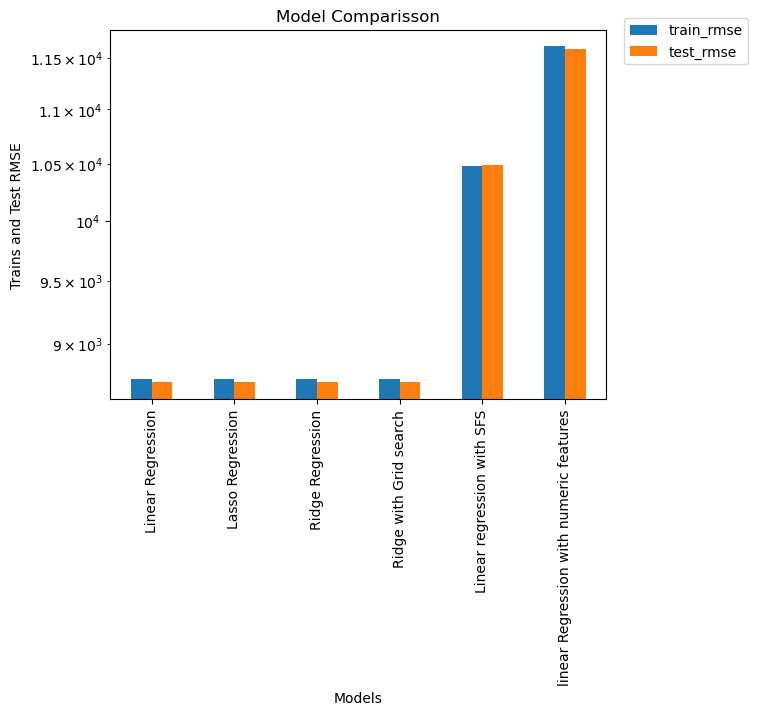

In [42]:
# Plotting the results obtained by executing different regression models. Comparing train mse and test mse
df_results[['model', 'train_rmse', 'test_rmse']].sort_values('test_rmse', ascending=True).plot(x='model', kind='bar', stacked=False, logy=True)

plt.xlabel("Models")
plt.ylabel("Trains and Test RMSE")
plt.title('Model Comparisson')
plt.legend(bbox_to_anchor=(1.3, 1.05))

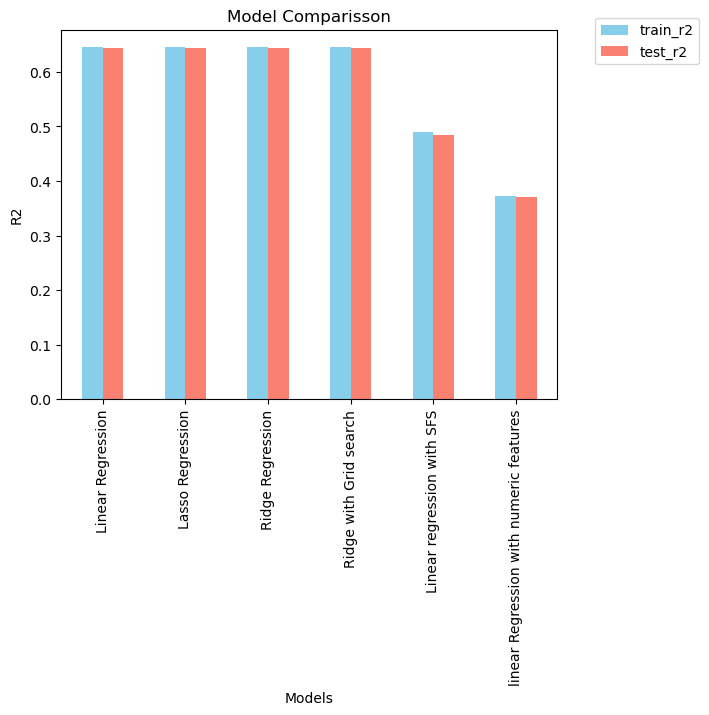

In [43]:
# Comparing final results for train r2 and test r2 by using visualization
df_results = pd.DataFrame(results)
df_results[['model', 'train_r2', 'test_r2']].sort_values('test_r2', ascending=False).plot(x='model', kind='bar', stacked=False, color=['skyblue', 'salmon'] )

plt.xlabel("Models")
plt.ylabel("R2")
plt.title('Model Comparisson')
plt.legend(bbox_to_anchor=(1.3, 1.05))

**Observations:**

Based on the evaluation graphs and performance metrics, the Linear Regression, Lasso Regression, Ridge Regression, and Ridge Regression with Grid Search CV all achieved very similar R² (\~0.64) and RMSE (\~8,700). While the small differences in performance are not statistically significant, the Linear Regression model remains a strong choice due to its simplicity and easy interpretability for business stakeholders compared to the regularized models.

The Linear Regression with numeric features and Sequential Feature Selection (SFS) approaches performed worse, showing lower R² values, indicating that using the full set of features with regularization (or even plain Linear Regression) captures the variability in car prices more effectively.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

In [44]:
# Top features deciding price value

feature_names = linreg_pipe.named_steps['col_transformer'].get_feature_names_out()
coefficients = linreg_pipe.named_steps['model'].coef_

feat_imp = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients,
    'abs_coefficient': abs(coefficients)
}).sort_values(by='abs_coefficient', ascending=False)

print(feat_imp.head(10))

                                  feature  coefficient  abs_coefficient
165                       remainder__year  6268.681888      6268.681888
166                   remainder__odometer -3615.293261      3615.293261
41             onehotencoder__fuel_diesel  2626.382284      2626.382284
43                onehotencoder__fuel_gas -1295.365479      1295.365479
114              onehotencoder__drive_4wd  1160.682122      1160.682122
160  onehotencoder__cylinders_4 cylinders -1160.317057      1160.317057
163  onehotencoder__cylinders_8 cylinders  1159.524173      1159.524173
126            onehotencoder__type_pickup  1063.556108      1063.556108
127             onehotencoder__type_sedan -1037.226644      1037.226644
115              onehotencoder__drive_fwd  -977.547811       977.547811


Top features influencing price are Year, Odometer, Fuel, Cylinders, Drive,  Type



In [45]:
#Plotting the relationship between car price and year of manufacture

plt.figure(figsize=(12,6))

# Scatter of all points (semi-transparent)
sns.scatterplot(
    data=cars_df, 
    x='year', 
    y='price', 
    alpha=0.2,  # makes dense points visible
    color='blue'
)

# Smoothed trend line of average price per year
sns.lineplot(
    data=cars_df, 
    x='year', 
    y='price', 
    estimator='mean',  # plots average price
    color='red', 
    linewidth=2,
    marker='o',
    errorbar=None
)

plt.title('Used Car Prices vs Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

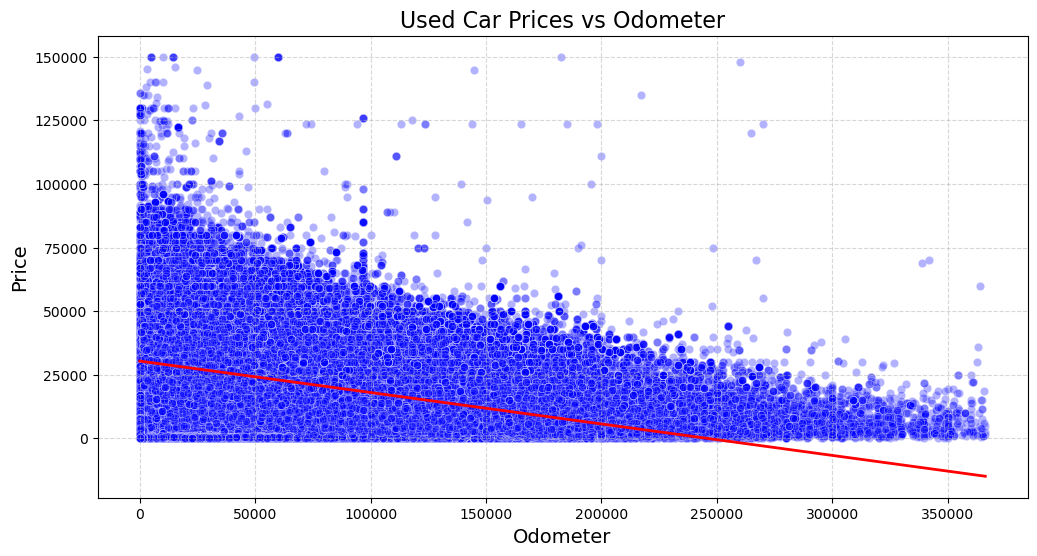

In [46]:
#Plotting the relationship between car price and odometer

plt.figure(figsize=(12,6))
sns.scatterplot(
    data=cars_df,
    x='odometer',
    y='price',
    alpha=0.3,       # transparency to handle overlaps
    color='blue'
)

# Regression line
sns.regplot(
    data=cars_df,
    x='odometer',
    y='price',
    scatter=False,   # don't repeat scatter
    color='red',
    line_kws={"linewidth":2}
)

plt.title('Used Car Prices vs Odometer', fontsize=16)
plt.xlabel('Odometer', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


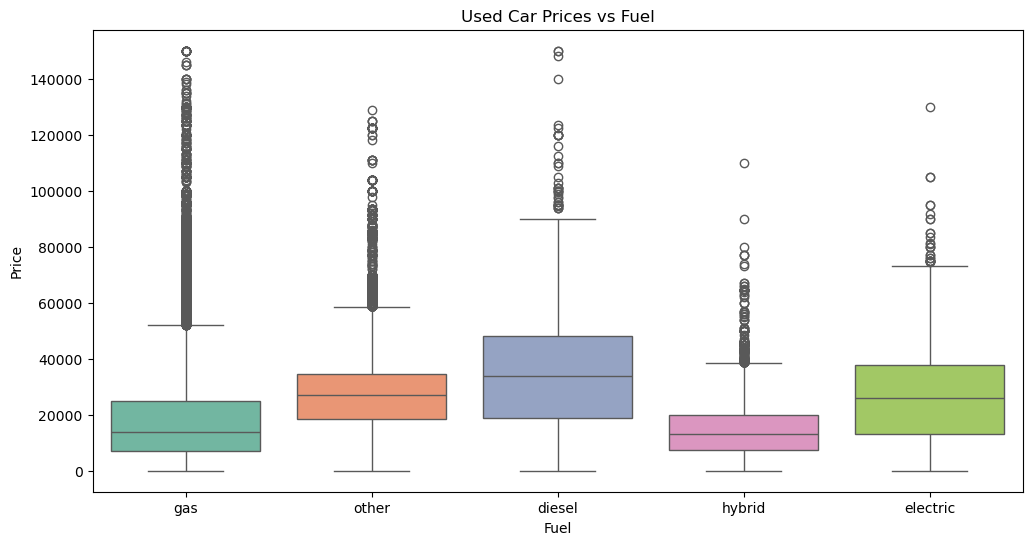

In [47]:
#Plotting the relationship between car price and Fuel type

plt.figure(figsize=(12,6))
sns.boxplot(x="fuel", y="price", data=cars_df, palette="Set2", hue="fuel")
plt.title("Used Car Prices vs Fuel")
plt.ylabel("Price")
plt.xlabel("Fuel")
plt.show()

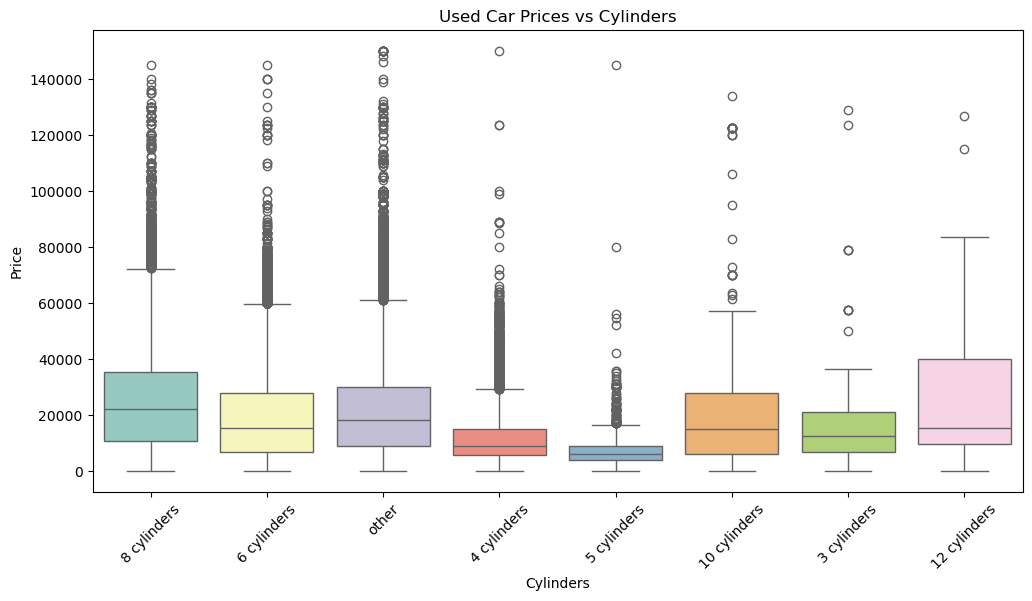

In [48]:
#Plotting the relationship between car price and Cylinder 

plt.figure(figsize=(12,6))
sns.boxplot(x="cylinders", y="price", data=cars_df, palette="Set3", hue="cylinders")
plt.title("Used Car Prices vs Cylinders")
plt.ylabel("Price")
plt.xlabel("Cylinders")
plt.xticks(rotation=45)
plt.show()

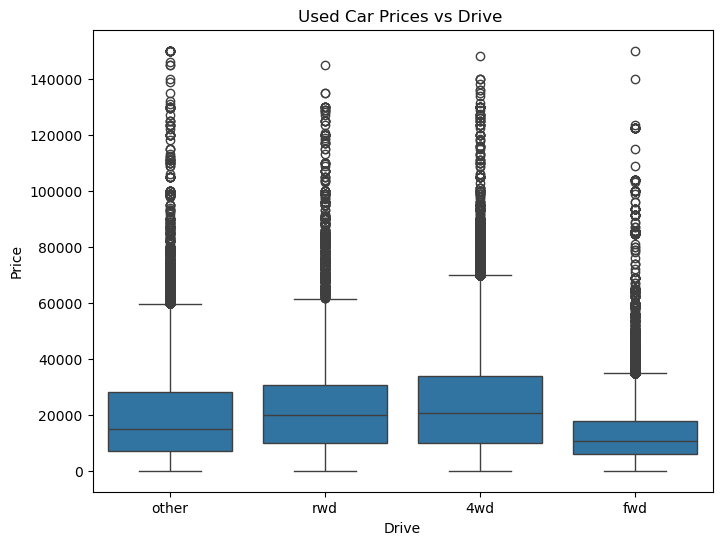

In [49]:
#Plotting the relationship between car price and Drive 
plt.figure(figsize=(8,6))
sns.boxplot(x="drive", y="price", data=cars_df)
plt.title("Used Car Prices vs Drive ")
plt.ylabel("Price")
plt.xlabel("Drive")
plt.show()

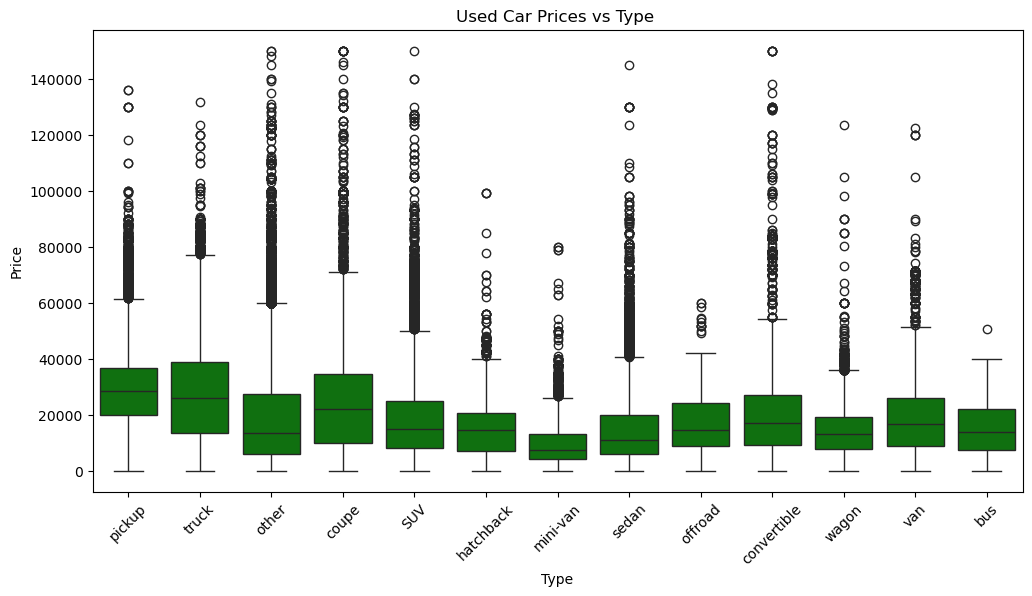

In [50]:
#Plotting the relationship between car price and Type 
plt.figure(figsize=(12,6))
sns.boxplot(x="type", y="price", data=cars_df, color="green")
plt.title("Used Car Prices vs Type ")
plt.ylabel("Price")
plt.xlabel("Type")
plt.xticks(rotation=45)
plt.show()

**Observations:**

1. Newer cars sell for significantly higher prices.
2. Cars with higher mileage tend to have lower resale value.
3. Diesel cars increase the resale price.
4. Gas cars slightly decrease the resale price.
5. 4-cylinder cars reduce the resale price.
6. 8-cylinder cars increase the resale price.
7. 4WD increases the price.
8. FWD slightly decreases the price.
9. Pickup trucks are more valuable and increase the price.
10. Sedans slightly decrease the resale price.


**Recommendations:**
  
1. Focus inventory on newer, low-mileage vehicles.
2. Prioritize diesel, 8-cylinder, pickup, and 4WD cars to maximize resale value.
3. Avoid overstocking sedans and high-mileage vehicles, as they bring lower returns.
4. Use predictive modeling for dynamic pricing to stay competitive.


**Next Steps:**

1. Explore more pricing models to get more accurate predictions.
2. Improve the quality of available car data to avoid losing useful information.
3. Use additional charts to better understand customer preferences.
4. Test the pricing model with new car listings to confirm its reliability.